# Figure 4 - An example plot showing skill

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-04-30 10:50:11.429923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 10:50:11.442736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 10:50:11.446653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    #'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : [  'uphp_rotated',
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    'use_coeff_channels': False,
                    'single_layer_mask': True,

                    'all_time_range': slice(3600-256, 3600),
                    #'train_time_range': slice(0, 2048),
                    #'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    #'num_train_batches': 128, 
                    #'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],

                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/main_models/window_all/shape_48_48_2/'
                    
            }

In [4]:
experiment_configs = {#'1point':{'window_size':1, 'num_inputs':6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'1point'},
                      '3point':{'window_size':3, 'num_inputs':3*3*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'3point'},
                      #'5point':{'window_size':5, 'num_inputs':5*5*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'5point'}    
                        }

In [9]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
for key in experiment_configs.keys():

    print('Starting to load in DT for: ' + key)
    
    experiment_configs[key]['DT'] = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                         filter_scales=common_config['filter_scales'], 
                         window_size = experiment_configs[key]['window_size'], 
                         time_sel = common_config['all_time_range'],
                         single_layer_mask_flag=common_config['single_layer_mask']
                         )

    print('Opening up eval sys: ' + key)
    experiment_configs[key]['eval_sys'] = evaluation.EvalSystem(simulation_data=experiment_configs[key]['DT'],
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs=experiment_configs[key]['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=experiment_configs[key]['exp_ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

    print('Reading model and predicting: ' + key)
    
    experiment_configs[key]['eval_sys'].read_ann_regression_model()
    experiment_configs[key]['eval_sys'].read_eval_data()
    experiment_configs[key]['eval_sys'].predict()
    experiment_configs[key]['eval_sys'].dimensionalize()

Starting to load in DT for: 3point
Opening up eval sys: 3point
Reading model and predicting: 3point


In [10]:
experiment_configs['3point']['eval_sys'].regress_sys.network.count_parameters()

5090

In [11]:
ds = experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset['DG']['100']

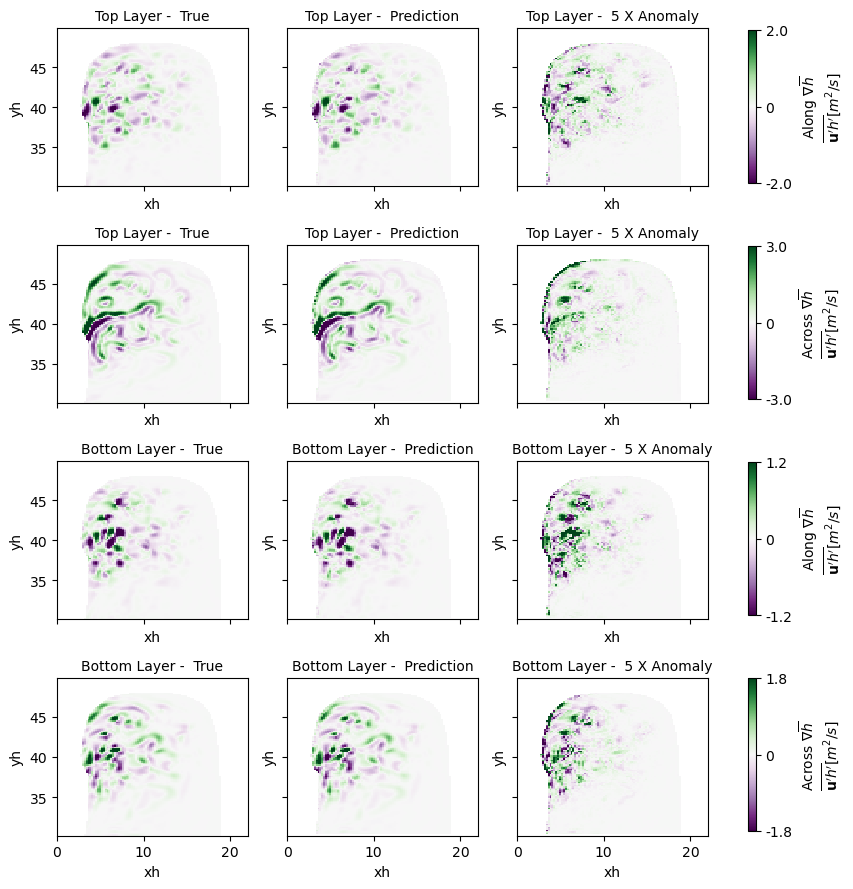

In [12]:
import matplotlib.pyplot as plt

# Select the first time index
time_idx = 0

# Define layer labels
layer_labels = ["Top Layer", "Bottom Layer"]

# Define separate vmin/vmax for each combination
vmin_uphp_top, vmax_uphp_top = -2, 2
vmin_vphp_top, vmax_vphp_top = -3., 3.
vmin_uphp_bottom, vmax_uphp_bottom = -1.2, 1.2
vmin_vphp_bottom, vmax_vphp_bottom = -1.8, 1.8

# **Slightly reduce panel height** (A4 width, slightly shorter height)
fig, axes = plt.subplots(4, 3, figsize=(8.27, 9), sharex=True, sharey=True)

# Define datasets per variable
data_vars = [
    ds.uphp_rotated, ds.uphp_rotated_pred, 5*(ds.uphp_rotated - ds.uphp_rotated_pred),
    ds.vphp_rotated, ds.vphp_rotated_pred, 5*(ds.vphp_rotated - ds.vphp_rotated_pred)
]

titles = ["True", "Prediction", "5 X Anomaly"]

# Iterate over layers (zl=0 → Top Layer, zl=1 → Bottom Layer)
for row, zl in enumerate([0, 1]):  # zl index order
    # Set vmin/vmax based on the layer
    row2 = row*2
    if row == 0:  # Top Layer
        vmin_uphp, vmax_uphp = vmin_uphp_top, vmax_uphp_top
        vmin_vphp, vmax_vphp = vmin_vphp_top, vmax_vphp_top
    else:  # Bottom Layer
        vmin_uphp, vmax_uphp = vmin_uphp_bottom, vmax_uphp_bottom
        vmin_vphp, vmax_vphp = vmin_vphp_bottom, vmax_vphp_bottom

    for col in range(3):  # (Original, Prediction, Anomaly)
        uphp_ax = axes[2 * row, col]  # Rows 0, 2 for uphp
        vphp_ax = axes[2 * row + 1, col]  # Rows 1, 3 for vphp
        
        # Plot uphp_rotated with adjusted vmin/vmax
        im1 = data_vars[col].isel(zl=zl, Time=time_idx).plot(
            ax=uphp_ax, add_colorbar=False, vmin=vmin_uphp, vmax=vmax_uphp, cmap="PRGn"
        )
        uphp_ax.set_title(f"{layer_labels[row]} -  {titles[col]}", fontsize=10)
        
        # Plot vphp_rotated with adjusted vmin/vmax
        im2 = data_vars[col + 3].isel(zl=zl, Time=time_idx).plot(
            ax=vphp_ax, add_colorbar=False, vmin=vmin_vphp, vmax=vmax_vphp, cmap="PRGn"
        )
        vphp_ax.set_title(f"{layer_labels[row]} -  {titles[col]}", fontsize=10)

    cbar_ax = fig.add_axes([0.91, 0.79 - row2 * 0.24, 0.01, 0.17])
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.set_label("Along "+r"$\nabla \overline{h}$"+' \n'+ "$\overline{\mathbf{u}'h'} [m^2/s]$")
    cbar.set_ticks([vmin_uphp, 0, vmax_uphp])
    cbar.ax.set_yticklabels([f"{vmin_uphp:.1f}", "0", f"{vmax_uphp:.1f}"])

    cbar_ax = fig.add_axes([0.91, 0.79 - (row2 + 1) * 0.24, 0.01, 0.17])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.set_label("Across "+r"$\nabla \overline{h}$"+' \n'+ "$\overline{\mathbf{u}'h'} [m^2/s]$")
    cbar.set_ticks([vmin_vphp, 0, vmax_vphp])
    cbar.ax.set_yticklabels([f"{vmin_vphp:.1f}", "0", f"{vmax_vphp:.1f}"])

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.88, 1])  # **Better spacing for colorbars**

#plt.savefig('maps_ML_skill.png', dpi=250)